Objective:  This exercise provides an opportunity to demonstrate our ability to combine data sets and produce meaningful results.  Specifically, we want to provide a decision maker with more than just data - we want to provide insights, understanding, and data driven choices.

In [1093]:
#Load our files
from google.colab import files
uploaded = files.upload()

Saving coaches_bp_dsa.csv to coaches_bp_dsa (5).csv
Saving stadium_bp_dsa.csv to stadium_bp_dsa (5).csv
Saving stats_bp_dsa.csv to stats_bp_dsa (5).csv


In [1094]:
#Create DataFrames
import pandas as pd
coaches = pd.read_csv('/content/coaches_bp_dsa.csv')
stadium = pd.read_csv('/content/stadium_bp_dsa.csv')
stats   = pd.read_csv('/content/stats_bp_dsa.csv')
#coaches

In [1095]:
#stadium

In [1096]:
#stats

In [1097]:
df = coaches.merge(stats)
df = df.merge(stadium)
#df

In [1098]:
#11 teams are missing the same Data
df.isnull().sum()

School                      0
Conf                        0
Coach                       0
 TotalPay                   5
 Graduation Rate (GSR)      0
W                          11
L                          11
 Ratio                     11
OffenceScore               11
Defense Score              11
Score                      11
PointsPerGame              11
 StadSize                   0
dtype: int64

In [1099]:
#Drop those with no pay data since this is our prediction target
df = df.dropna(subset = [' TotalPay '])

In [1100]:
#A quick search shows the data is from 2016, we can easily fill in the missing W/L
def fill_team_stats(df, school, w=pd.NA, l=pd.NA, ppg=pd.NA):
  df.loc[df['School'] == school, ['W']] = w
  df.loc[df['School'] == school, ['L']] = l
  df.loc[df['School'] == school, ['PointsPerGame']] = ppg
  df.loc[df['School'] == school, [' Ratio ']] = float(w/l)

fill_team_stats(df, 'Bowling Green', 4, 8, 24.8)
fill_team_stats(df, 'Central Florida', 6, 7, 28.8)
fill_team_stats(df, 'Coastal Carolina', 10, 2, 37.25)
fill_team_stats(df, 'Liberty', 6, 5, 27.45)
fill_team_stats(df, 'Louisiana-Lafayette', 6, 7, 23.62)
fill_team_stats(df, 'Miami (Fla.)', 9, 4, 34.3)
fill_team_stats(df, 'Miami (Ohio)', 6, 7, 22.8)
fill_team_stats(df, 'Mississippi', 6, 7, 30.4)
fill_team_stats(df, 'Pittsburgh', 8, 5, 40.9)
fill_team_stats(df, 'Southern California', 10, 3, 34.4)
fill_team_stats(df, 'Southern Methodist', 7, 2, 34.4)

In [1101]:
df

,School,Conf,Coach,TotalPay,Graduation Rate (GSR),W,L,Ratio,OffenceScore,Defense Score,Score,PointsPerGame,StadSize
0,Air Force,Mt. West,Troy Calhoun,"$885,000",83,10.0,3.0,3.333333,4.96,-0.87,4.09,78.16,"46,692"
1,Akron,MAC,Terry Bowden,"$412,500",45,5.0,7.0,0.714286,-0.40,-6.12,-6.52,72.64,"30,000"
2,Alabama,SEC,Nick Saban,"$8,307,000",79,14.0,1.0,14.000000,8.01,17.62,25.62,90.38,"101,821"
3,Appalachian State,Sun Belt,Scott Satterfield,"$712,500",57,10.0,3.0,3.333333,-0.86,9.68,8.83,70.76,"24,050"
4,Arizona,Pac-12,Kevin Sumlin,"$2,000,000",74,3.0,9.0,0.333333,1.01,-5.64,-4.63,74.42,"51,811"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,Washington State,Pac-12,Mike Leach,"$3,500,000",93,8.0,5.0,1.600000,5.70,3.33,9.03,84.22,"32,248"
114,West Virginia,Big 12,Dana Holgorsen,"$3,617,500",66,10.0,3.0,3.333333,4.01,5.56,9.57,78.75,"60,000"
115,Western Michigan,MAC,Tim Lester,"$800,000",74,13.0,1.0,13.000000,7.61,4.42,12.03,86.24,"30,200"
116,Wisconsin,Big Ten,Paul Chryst,"$3,750,000",71,11.0,3.0,3.666667,2.13,13.17,15.30,78.74,"80,321"


In [1102]:
#Define the features to use in our model
features = ['Conf',' Graduation Rate (GSR) ', 'W', 'L', ' Ratio ', 'OffenceScore', 'Defense Score', 'Score', 'PointsPerGame', ' StadSize ']

#Deleting Ratio and Score categories helps limit some of our over fitting and provides better generalization
#Comment out below if you want to include all provided features
features = ['Conf',' Graduation Rate (GSR) ', 'W', 'L', 'OffenceScore', 'Defense Score', 'PointsPerGame', ' StadSize ']

In [1103]:
#Get our independent variables
X = df[features]
#X

In [1104]:
#Use one hot encoding for categorical data (Conference)
from sklearn.preprocessing import OneHotEncoder

confs = ['AAC', 'ACC', 'Big 12', 'Big Ten', 'C-USA', 'Ind.', 'MAC', 'Mt. West', 'Pac-12', 'SEC', 'Sun Belt']

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(X[['Conf']]).toarray())
#merge one-hot encoded columns back with original DataFrame
final_X = X.join(encoder_df)
#Rename the Cols
final_X.columns = features + confs
#Drop original Conf column
final_X = final_X.drop('Conf', axis=1)
#final_X

In [1105]:
#Stad Size str to int
def fix_stad_size(s): return int(s.strip().replace(',',''))
final_X[' StadSize '] = final_X[' StadSize '].apply(fix_stad_size)
#final_X

In [1106]:
#Use KNN to fill in other missing data
from sklearn.impute import KNNImputer
impute_knn = KNNImputer(n_neighbors=2)
data = impute_knn.fit_transform(final_X)
imputed_X = pd.DataFrame(data=data, columns=final_X.columns)
#imputed_X

###Visualize Data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


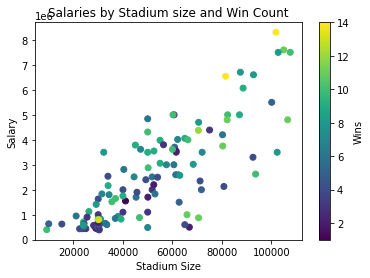

In [1107]:
import matplotlib.pyplot as plt
x = imputed_X[' StadSize '].values  #Stadium Size
c = imputed_X['W'].values           #Win Count
y = df[' TotalPay ']                #Total Pay, Dependant Variable
#Turn Total Pay stings into ints
y = y.str.replace('$', '')
y = y.str.replace(',', '')
y = y.str.strip()
y = y.astype(int)
y = y.values
df[' TotalPay '] = y
#Plot
plt.scatter(x, y, c=c)
plt.title('Salaries by Stadium size and Win Count')
plt.ylabel('Salary')
plt.xlabel('Stadium Size')
plt.colorbar(label='Wins')
plt.show()
#x, y

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


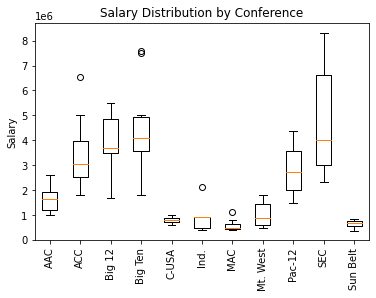

In [1108]:
#Plot whisker graphs for conferences
ticks = ['AAC', 'ACC', 'Big 12', 'Big Ten', 'C-USA', 'Ind.', 'MAC','Mt. West', 'Pac-12', 'SEC', 'Sun Belt']
data = []
for conf in ticks:
  salaries = df[df['Conf']==conf][' TotalPay ']
  data.append(salaries.values)
plt.boxplot(data, labels=ticks)
plt.xticks(rotation=90)
plt.title('Salary Distribution by Conference')
plt.ylabel('Salary')
plt.show()

###Build Prediction Model

In [1109]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [1110]:
X_train, X_test, y_train, y_test = train_test_split(imputed_X.values, y, random_state=1)

In [1111]:
#Scale Data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1112]:
#Build and fit model
linreg = LinearRegression().fit(X_train_scaled, y_train)

In [1113]:
#Get data for OU coach
ou = imputed_X.iloc[77].copy()
#ou

In [1114]:
#Make instance with OU coach in SEC
ou_sec = ou.copy()
ou_sec['Big Ten']=0.
ou_sec['SEC']=1.

In [1115]:
#ou, ou_sec

In [1116]:
#Transform OU data for model
ou_scaled = scaler.transform([ou.values, ou_sec.values])
#ou_scaled

In [1117]:
preds = linreg.predict(ou_scaled)
print(f"OU Coach Salary: ${round(preds[0],2)}\nOU (SEC)Coach Salary: ${round(preds[1],2)}")

OU Coach Salary: $1862732.07
OU (SEC)Coach Salary: $2800614.87


In [1118]:
train_score = linreg.score(X_train_scaled, y_train)
test_score = linreg.score(X_test_scaled, y_test)
train_score, test_score

(0.7363059451265332, 0.7159147417491585)

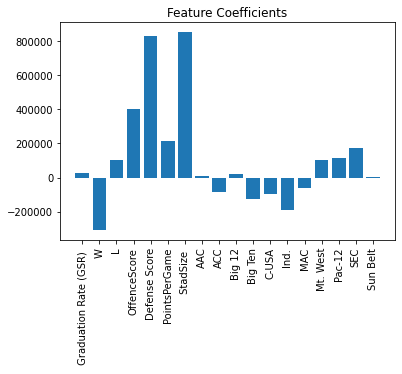

In [1119]:
#Plot Feature Coefs
plt.bar(imputed_X.columns, linreg.coef_)
plt.title('Feature Coefficients')
plt.xticks(rotation=90)
plt.show()

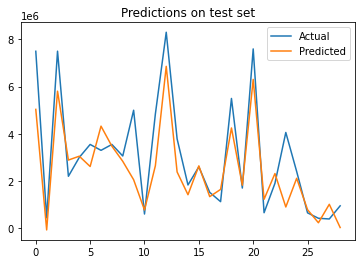

In [1120]:
preds = linreg.predict(X_test_scaled)
diffs = [act-pred for act,pred in zip(y_test,preds)]
plt.plot(range(len(X_test_scaled)), y_test)
plt.plot(range(len(X_test_scaled)), preds)
plt.title('Predictions on test set')
plt.legend(['Actual', 'Predicted', '% wrong'])
plt.show()

#What is the recommended salary for the OU football coach?

Our model's recommended salary for the OU football coach is: $1,862,732

##What would the appropiate salary be if OU moved to the SEC?

Our model's recommended salary for the OU football coach in the SEC conference is: $2,800,614

##What schools did we drop from the data and why?

We dropped any schools that didn't have data for the Total pay of their coach because that is our target value. While we imputed some other values we don't want to do this for target values.

##What is the single biggest impact on salary size?

Stadium size has the biggest impact on salary size.